# Veille

Quelle système de recommandation allez vous mettre en place ?

content base similarité non
colaboratif vectoring user/artist

Qu'est ce que Lightfm ?

LightFM est une implémentation Python d'un certain nombre d'algorithmes de recommandation populaires pour les feedback implicite et explicit...

Qu'est ce un système de recommandation dit à "implicit feedback" ? Et a "explicit feedback ?

In [2]:
import pandas as pd
import numpy as np

In [3]:
plays = pd.read_csv('lastfm/user_artists.dat', sep='\t')
artists = pd.read_csv('lastfm/artists.dat', sep='\t', usecols=['id','name'])

# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)

artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
print(artist_rank)



                    totalUsers  totalPlays     avgPlays
name                                                   
Britney Spears             522     2393140  4584.559387
Depeche Mode               282     1301308  4614.567376
Lady Gaga                  611     1291387  2113.563011
Christina Aguilera         407     1058405  2600.503686
Paramore                   399      963449  2414.659148
...                        ...         ...          ...
Morris                       1           1     1.000000
Eddie Kendricks              1           1     1.000000
Excess Pressure              1           1     1.000000
My Mine                      1           1     1.000000
A.M. Architect               1           1     1.000000

[17632 rows x 3 columns]


In [4]:
# Merge into ap matrix
ap = ap.join(artist_rank, on="name", how="inner") \
    .sort_values(['playCount'], ascending=False)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)
#print(ap)

# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("sparsity: %.2f" % sparsity)
#print(ap.il)

sparsity: 0.28


In [5]:
ap.pivot

<bound method DataFrame.pivot of           id             name  userID  artistID  playCount  totalUsers  \
2800      72     Depeche Mode    1642        72     352698         282   
35843    792           Thalía    2071       792     324663          26   
27302    511               U2    1094       511     320725         185   
8152     203             Blur    1905       203     257978         114   
26670    498         Paramore    1664       498     227829         399   
...      ...              ...     ...       ...        ...         ...   
38688    913  Destiny's Child    1810       913          1          83   
32955    697              Sia    1290       697          1          56   
71811   4988   Chris Spheeris     510      4988          1           5   
91319  17080      Haylie Duff    1851     17080          1           1   
63982   3201        Kate Bush     344      3201          1          42   

       totalPlays      avgPlays  playCountScaled  
2800      1301308   4614.56

In [6]:
from scipy.sparse import csr_matrix

# Build a sparse matrix
X = csr_matrix(ratings)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()


rating matrix shape (1892, 17632)


In [16]:
artist_names[9]

'Grendel'

In [20]:
i = list(artist_names).index('Grendel') # i will return index of 2, which is 1
i

9

In [8]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

# Build data references + train test
Xcoo = X.tocoo()
data = Dataset()
data.fit(np.arange(n_users), np.arange(n_items))
interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions,random_state=42)

# Ignore that (weight seems to be ignored...)
#train = train_.tocsr()
#test = test_.tocsr()
#train[train==1] = X[train==1]
#test[test==1] = X[test==1]

# To be completed...

In [9]:
# Train
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10, num_threads=2)

In [10]:
# Evaluate
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()


print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))



Precision: train 0.38, test 0.13.
AUC: train 0.97, test 0.86.


In [11]:
# Predict
scores = model.predict(0, np.arange(n_items))
top_items = artist_names[np.argsort(-scores)]
print(top_items)


['Pet Shop Boys' 'Depeche Mode' 'Lady Gaga' ... 'Gorgoroth'
 'Enlightenment' 'Autopsy']


In [12]:
# Train
model1 = LightFM(learning_rate=0.05, loss='logistic',random_state=42)
model1.fit(train, epochs=10, num_threads=2)

In [13]:
# Evaluate
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model1, train).mean()
test_auc = auc_score(model1, test, train_interactions=train).mean()


print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.38, test 0.13.
AUC: train 0.89, test 0.81.


In [23]:
model1 = LightFM(learning_rate=0.05, loss='warp',random_state=42)
log_model=[]
log_model_test=[]
for i in range(0,30):
    model1.fit_partial(train, epochs=1)
    log_model.append(auc_score(model1, train).mean())
    log_model_test.append(auc_score(model1, test).mean())


In [73]:
log_model

[0.8655998,
 0.89666367,
 0.9149277,
 0.9275651,
 0.93750656,
 0.9454431,
 0.9517508,
 0.95682406,
 0.9609533,
 0.9643268]

In [20]:
import matplotlib.pyplot as plt

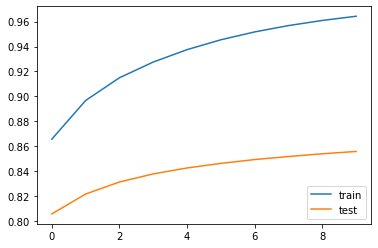

In [22]:
#len(log_model)
#x = np.array(len(log_model))
plt.plot(np.array(log_model))
plt.plot(np.array(log_model_test))
plt.legend(['train','test'], loc='lower right')

In [58]:
def get_recommendations(userID):
    scores = model1.predict(userID, np.arange(n_items))
    top_items = artist_names[np.argsort(-scores)]
    return top_items

In [64]:
get_recommendations(2)[:10]

array(['Depeche Mode', 'The Cure', 'Muse', 'Lady Gaga', 'The Beatles',
       'David Bowie', 'Coldplay', 'Madonna', 'Placebo', 'Rammstein'],
      dtype=object)

In [30]:
from sklearn.model_selection import ParameterGrid

In [59]:
## Construction de Grid-search manuelle

from itertools import product 
import copy 

## construire plusieurs modèles avec différentes valeurs des hyperparamètres mixées

        
def const_modeles_recom_grid(param_grid,base_model):
    
    
    modeles= defaultdict(object) ## initialisation
    
    keys, values = zip(*param_grid.items())
    
    for v in product(*values):
        
        params = dict(zip(keys, v))

        name = "-".join([str(x) for x in v])

        modeles[name]=base_model(**params)
    return modeles




In [60]:
##### test

param_grid = dict()

param_grid['learning_rate'] = [0.05, 0.1,0.2]
param_grid['loss'] = ["warp", "bpr"]


In [33]:
list(ParameterGrid(grid)) == [{'loss': 'warp'},{'loss': 'logistic'}]


True

In [55]:
a = ParameterGrid(grid)[0]
a

{'loss': 'warp'}

In [50]:
model1 = LightFM(learning_rate=0.05,loss=a,random_state=42)

AssertionError: 

In [ ]:
#model1 = LightFM(learning_rate=0.05, loss='warp',random_state=42)

In [62]:
param_grid = {
    'learning_rate': [0.05 , 0.08],
    'learning_schedule':['adagrad','adadelta'],
    'loss': ['warp','bpr','logistic','warp-kos']

}# Create a based model

list(ParameterGrid(param_grid))

[{'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'warp'},
 {'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'bpr'},
 {'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'logistic'},
 {'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'warp-kos'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'warp'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'bpr'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'logistic'},
 {'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'warp-kos'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'warp'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'bpr'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'logistic'},
 {'learning_rate': 0.08, 'learning_schedule': 'adagrad', 'loss': 'warp-kos'},
 {'learning_rate': 0.08, 'learning_schedule': 'adadelta', 'loss': 'warp'},
 {'learning_

In [63]:
auc_score_values = []

for grid in ParameterGrid(param_grid):
    model = LightFM(**grid)
    pred = model.fit(train)
    auc_score_values.append(round(auc_score(model, test, train_interactions=train).mean(),3))

max_value = max(auc_score_values) 
max_index = auc_score_values.index(max_value) 
ParameterGrid(param_grid)[max_index ].items()

dict_items([('loss', 'warp'), ('learning_schedule', 'adadelta'), ('learning_rate', 0.08)])

In [70]:
grid

{'learning_rate': 0.08, 'learning_schedule': 'adadelta', 'loss': 'warp-kos'}

In [89]:
model2 = LightFM(learning_rate=0.08,learning_schedule='adadelta',loss='warp-kos',random_state=42)
model2.fit(train, epochs=100, num_threads=2)

In [90]:
train_auc = auc_score(model2, train).mean()
test_auc = auc_score(model2, test).mean()


#print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.93, test 0.86.
